<a href="https://colab.research.google.com/github/MASAKI-Matsumoto-U/Swin-Unet/blob/main/02_karaage_ai_book_image_classification_viz_grad_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GradCamによるAIモデルの可視化

[VizGradCAM](https://github.com/gkeechin/vizgradcam)というツールを使ってGradCamによる画像認識AIモデルの可視化をするノートブックです。

## 最初の準備

データのダウンロード

In [1]:
!git clone https://github.com/karaage0703/janken_dataset datasets
!rm -rf datasets/.git
!rm datasets/LICENSE

Cloning into 'datasets'...
remote: Enumerating objects: 210, done.
remote: Total 210 (delta 0), reused 0 (delta 0), pack-reused 210
Receiving objects: 100% (210/210), 4.60 MiB | 17.69 MiB/s, done.
Resolving deltas: 100% (3/3), done.


データを訓練データとテストデータに分けます

In [2]:
dataset_original_dir = 'datasets'
dataset_root_dir = 'target_datasets'

In [3]:
!wget https://raw.githubusercontent.com/karaage0703/karaage-ai-book/master/util/split_train_val.py

--2022-06-28 10:19:04--  https://raw.githubusercontent.com/karaage0703/karaage-ai-book/master/util/split_train_val.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2683 (2.6K) [text/plain]
Saving to: ‘split_train_val.py’

split_train_val.py  100%[===================>]   2.62K  --.-KB/s    in 0s      

2022-06-28 10:19:04 (55.4 MB/s) - ‘split_train_val.py’ saved [2683/2683]



In [4]:
import split_train_val
split_train_val.image_dir_train_val_split(
    dataset_original_dir, dataset_root_dir, train_size=0.67)

datasets/pa copy is done
datasets/choki copy is done
datasets/gu copy is done
processing is done


In [5]:
train_dir = 'target_datasets/train'
val_dir = 'target_datasets/val'

ラベルの作成をします

In [6]:
import os
labels = [d for d in os.listdir(dataset_original_dir) \
    if os.path.isdir(os.path.join(dataset_original_dir, d))]
labels.sort()
print(labels)

NUM_CLASSES = len(labels)

['choki', 'gu', 'pa']


必要なライブラリをインポート

In [7]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.8.2


## モデルの学習
最短でモデルの学習をします。

詳細は[ノートブック](https://colab.research.google.com/drive/13kLjdoz23fQIRT_zYR196pSxFEPHOS2k?usp=sharing)参照ください。

手っ取り早く、学習済みのモデルを使用したい人はここは飛ばして、学習済みモデルの可視化にいってください。

In [8]:
import sys
import os
import shutil

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# 学習率
LEARNING_RATE = 0.001
# エポック（世代数）
EPOCHS = 20
# バッチサイズ
BATCH_SIZE = 8

In [10]:
IMAGE_SIZE = 64

train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)

train_data = train_data_gen.flow_from_directory(
    train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True)

validation_data = val_data_gen.flow_from_directory(
    val_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True)

Found 111 images belonging to 3 classes.
Found 56 images belonging to 3 classes.


In [11]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
#opt = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE)

model.compile(opt, loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 62, 62, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 64)        0         
                                                        

AIモデルの学習を行います

In [13]:
%%time
history = model.fit(train_data, epochs=5, validation_data=validation_data, verbose=1)

Epoch 1/5
14/14 [==============================] - 12s 50ms/step - loss: 2.0918 - accuracy: 0.2252 - val_loss: 1.0911 - val_accuracy: 0.3036
Epoch 2/5
14/14 [==============================] - 0s 31ms/step - loss: 1.0670 - accuracy: 0.5135 - val_loss: 1.0332 - val_accuracy: 0.4464
Epoch 3/5
14/14 [==============================] - 0s 30ms/step - loss: 0.9119 - accuracy: 0.5766 - val_loss: 0.8787 - val_accuracy: 0.4821
Epoch 4/5
14/14 [==============================] - 0s 31ms/step - loss: 0.6881 - accuracy: 0.7297 - val_loss: 0.7527 - val_accuracy: 0.7500
Epoch 5/5
14/14 [==============================] - 0s 31ms/step - loss: 0.4837 - accuracy: 0.8649 - val_loss: 0.5193 - val_accuracy: 0.8214
CPU times: user 5.65 s, sys: 1.13 s, total: 6.78 s
Wall time: 13.9 s


モデルを保存します

In [14]:
model.save('./my_model.h5')

## GradCamによる可視化

### GradCamの準備

[VizGradCAM](https://github.com/gkeechin/vizgradcam)のダウンロード

In [44]:
!wget https://raw.githubusercontent.com/gkeechin/vizgradcam/main/gradcam.py

--2022-06-28 10:20:14--  https://raw.githubusercontent.com/gkeechin/vizgradcam/main/gradcam.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3290 (3.2K) [text/plain]
Saving to: ‘gradcam.py.1’

gradcam.py.1        100%[===================>]   3.21K  --.-KB/s    in 0s      

2022-06-28 10:20:14 (57.2 MB/s) - ‘gradcam.py.1’ saved [3290/3290]



ライブラリの読み込み

In [45]:
from gradcam import VizGradCAM
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import glob
import numpy as np

テストデータの読み込み

In [17]:
test_gradcam_images = glob.glob(val_dir + '/*/*')
test_images = []
for test_gradcam_image in test_gradcam_images:
  test_image = img_to_array(load_img(test_gradcam_image , target_size=(64, 64)))
  test_images.append(test_image/255.0)

データをシャッルフルします

In [18]:
import random
random.shuffle(test_images)

テストデータを確認します。

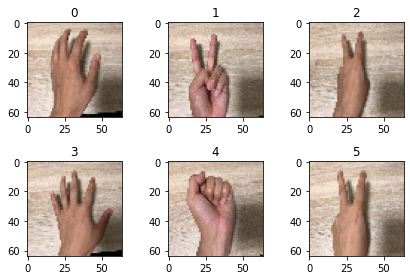

In [19]:
import matplotlib.pyplot as plt
image_numb = 6 # 3の倍数を指定してください
for i in range(0, image_numb):
  ax = plt.subplot(image_numb // 3, 3, i + 1)
  plt.tight_layout()
  ax.set_title(str(i))
  plt.imshow(test_images[i])

### 先程学習したモデルでの可視化

先程学習したモデルを使った可視化を行います。

学習済のモデルを使う場合は、ここを飛ばして次にいってください。

In [20]:
keras_model = tf.keras.models.load_model("my_model.h5")
keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 62, 62, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 64)        0         
                                                        

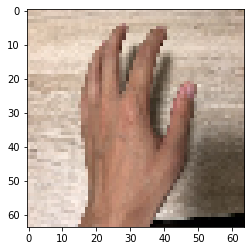

In [21]:
plt.imshow(test_images[0])

In [22]:
test_img = test_images[0][np.newaxis]


In [23]:
test_img = np.asarray(test_img)
test_img.shape

(1, 64, 64, 3)

In [24]:
preds = model.predict(test_img)

In [25]:
preds

array([[0.02620408, 0.02057399, 0.953222  ]], dtype=float32)

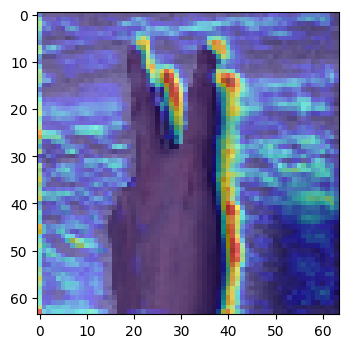

In [26]:
VizGradCAM(model, test_images[i], plot_results=True, interpolant=0.5)

In [27]:
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.models import Model

In [28]:
last_conv_layer = next(
        x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D)
    )

In [29]:
last_conv_layer.name

'conv2d_1'

In [30]:
test_img[0].shape

(64, 64, 3)

In [31]:
img = np.expand_dims(test_img[0], axis=0)
print(img.shape)

(1, 64, 64, 3)


In [32]:
prediction = model.predict(img)
print(prediction)

[[0.02620408 0.02057399 0.953222  ]]


In [33]:
prediction_idx = np.argmax(prediction)
print(prediction_idx)

2


In [34]:
target_layer = model.get_layer(last_conv_layer.name)
target_layer.output

<KerasTensor: shape=(None, 62, 62, 64) dtype=float32 (created by layer 'conv2d_1')>

In [35]:
gradient_model = Model([model.inputs], [target_layer.output, model.output])

In [36]:
gradient_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 62, 62, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                           

In [37]:
 conv2d_out, prediction = gradient_model(img)

In [49]:
np.array(conv2d_out[0][:,:,0]).shape

(1, 62, 62, 64)

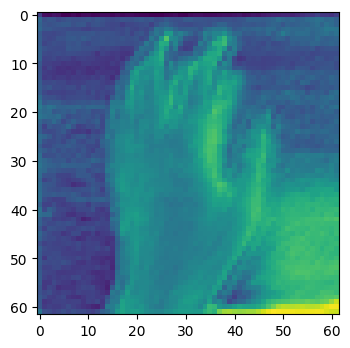

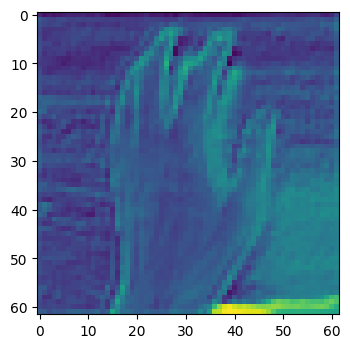

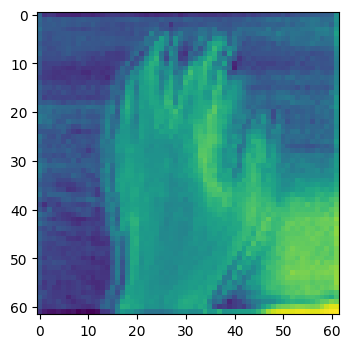

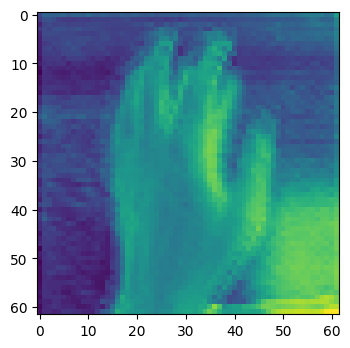

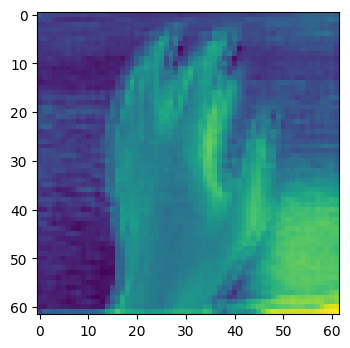

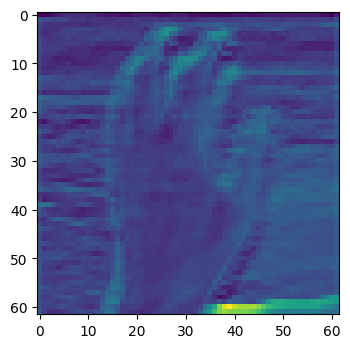

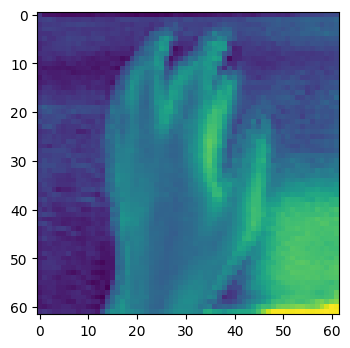

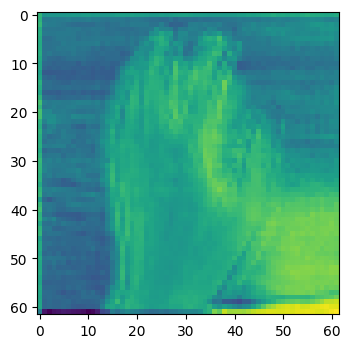

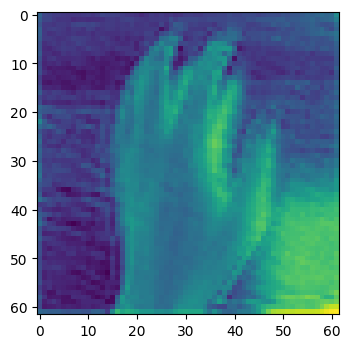

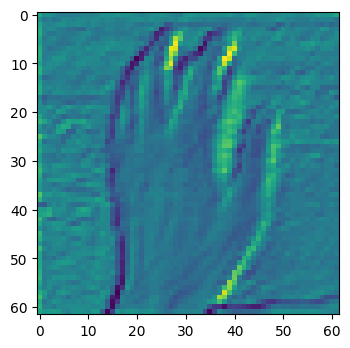

In [50]:
for i in range(10):
  plt.imshow(np.array(conv2d_out[0][:,:,i]))
  plt.show()

In [59]:
loss = prediction[:,1]

In [61]:
with tf.GradientTape() as tape:
      gradient_model = Model([model.inputs], [target_layer.output, model.output])
      conv2d_out, prediction = gradient_model(img)
      # Obtain the Prediction Loss
      loss = prediction[:, prediction_idx]

gradients = tape.gradient(loss, conv2d_out)

In [65]:
output = conv2d_out[0]

In [66]:
weights = tf.reduce_mean(gradients[0], axis=(0, 1))
weights.shape

TensorShape([64])

In [67]:
output.shape[0:2]

TensorShape([62, 62])

In [68]:
activation_map = np.zeros(output.shape[0:2], dtype=np.float32)


In [69]:
for idx, weight in enumerate(weights):
      activation_map += weight * output[:, :, idx]

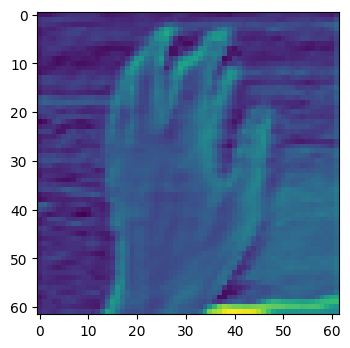

In [71]:
plt.imshow(activation_map)

In [72]:
original_img = test_img[0]
activation_map = cv2.resize(
        activation_map.numpy(), (original_img.shape[1], original_img.shape[0])
    )

In [80]:
# Ensure No Negative Numbers
activation_map = np.maximum(activation_map, 0)

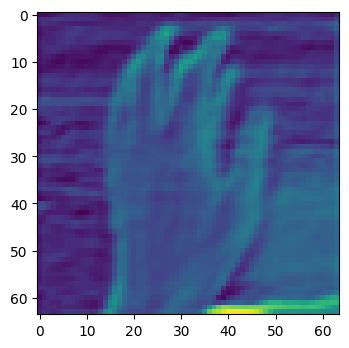

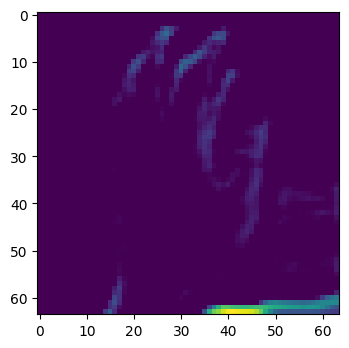

In [77]:
plt.imshow(activation_map)
plt.show()
plt.imshow(activation_map_max)
plt.show()

In [82]:
activation_map = (activation_map - activation_map.min()) / (
        activation_map.max() - activation_map.min()
    )
activation_map = np.uint8(255 * activation_map)

In [83]:
heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

In [84]:
original_img = np.uint8(
        (original_img - original_img.min())
        / (original_img.max() - original_img.min())
        * 255
    )

In [85]:
cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

In [86]:
plt.rcParams["figure.dpi"] = 100

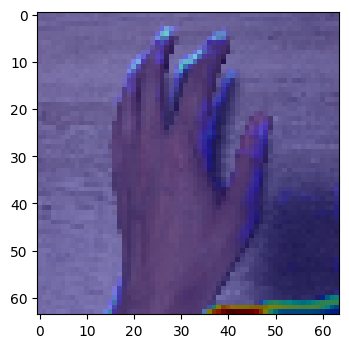

In [88]:
interpolant = 0.5
plt.imshow(
          np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant))
      )

In [39]:
def vizgradcam_plot(model):
  for i in range(16):
    plt.rcParams["figure.dpi"] = 250
    plt.subplot(4, 4, i+1)
    plt.tight_layout()
    plt.axis('off')
    test_img = test_images[i][np.newaxis]
    test_img = np.asarray(test_img)
    preds = model.predict(test_img)
    plt.title("Prediction: " + str(labels[np.argmax(preds[0])]),fontsize = 4)
    VizGradCAM(model, test_images[i], plot_results=True, interpolant=0.5)

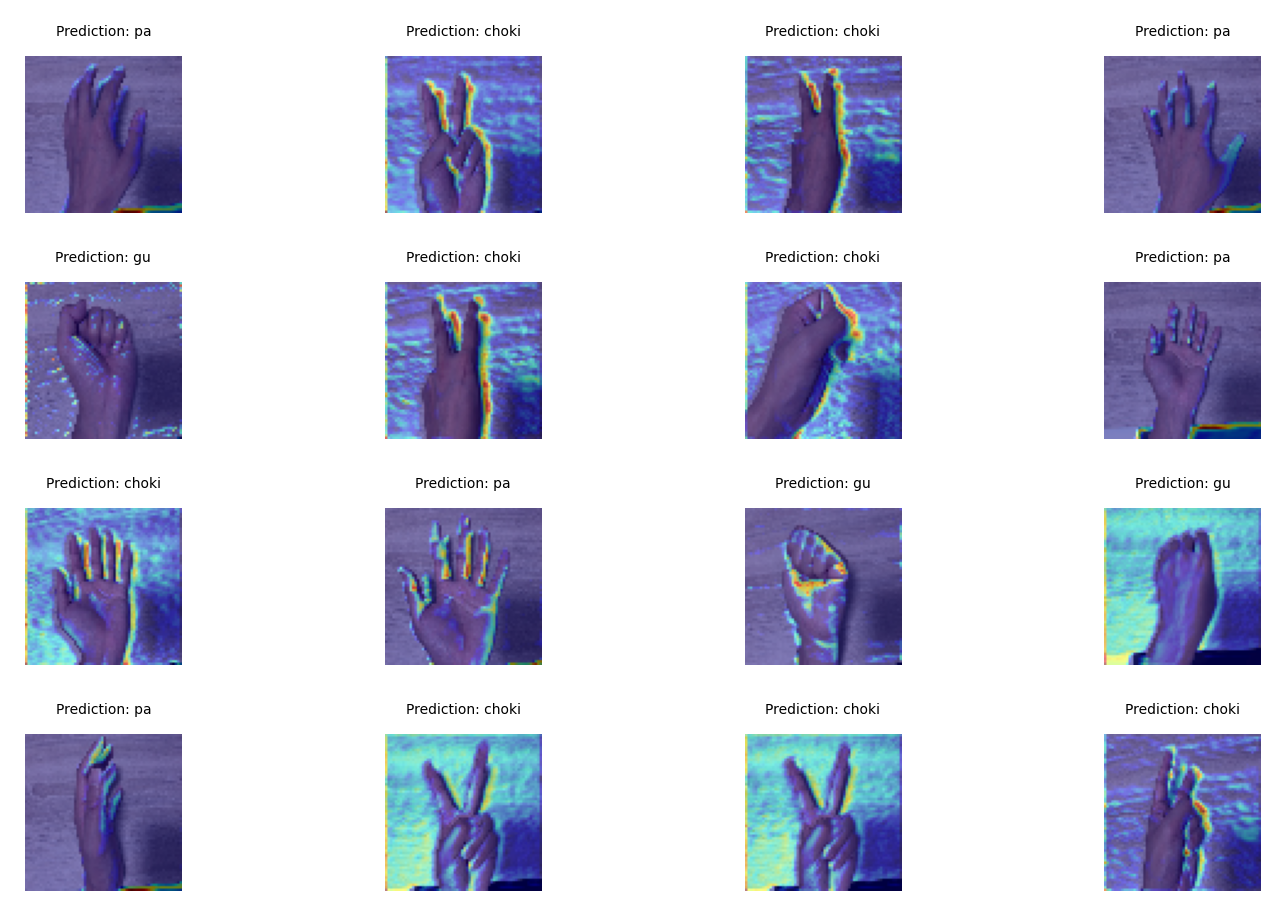

In [40]:
vizgradcam_plot(keras_model)

### 学習済みのモデルを使って可視化

学習済のモデルを使って可視化します。

In [41]:
!wget "https://drive.google.com/uc?export=download&id=1M1qcogcN8NTCXoyEDRVoBfE7e5DxxN56" -O cnnnet.h5

--2022-06-28 10:19:32--  https://drive.google.com/uc?export=download&id=1M1qcogcN8NTCXoyEDRVoBfE7e5DxxN56
Resolving drive.google.com (drive.google.com)... 74.125.195.113, 74.125.195.100, 74.125.195.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vkf5qdalm4grvma51fiprjpl9uj90vcp/1656411525000/14527627736407232059/*/1M1qcogcN8NTCXoyEDRVoBfE7e5DxxN56?e=download [following]
--2022-06-28 10:19:36--  https://doc-10-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vkf5qdalm4grvma51fiprjpl9uj90vcp/1656411525000/14527627736407232059/*/1M1qcogcN8NTCXoyEDRVoBfE7e5DxxN56?e=download
Resolving doc-10-7k-docs.googleusercontent.com (doc-10-7k-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-10-7k-docs.googleusercontent.com (doc-10-7k-docs

In [46]:
keras_model = tf.keras.models.load_model("cnnnet.h5")
keras_model.summary()

OSError: ignored

In [ ]:
vizgradcam_plot(keras_model)

## まとめ

[VizGradCAM](https://github.com/gkeechin/vizgradcam)というツールを使って、データの可視化を実施しました。

## 参考リンク

- https://github.com/gkeechin/vizgradcam
- https://github.com/gkeechin/vizgradcam/blob/main/examples/custom_model_example.ipynb